In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [30]:
# Configuration
IMG_SIZE = (300, 300)  # EfficientNet-B3 default
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42

DATA_DIR = "/kaggle/input/species-dataset/species_classifier_dataset"  # change if needed


In [31]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)


Found 5682 files belonging to 2 classes.
Found 117 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


In [32]:
preprocessing = keras.Sequential([
    layers.Rescaling(1./255),
], name="preprocessing")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [33]:
base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = preprocessing(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [34]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [35]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 95s 332ms/step - accuracy: 0.5064 - loss: 0.7007 - val_accuracy: 0.5470 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.5143 - loss: 0.6962 - val_accuracy: 0.6154 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.5065 - loss: 0.6983 - val_accuracy: 0.4786 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.5097 - loss: 0.6969 - val_accuracy: 0.5983 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5138 - loss: 0.6992 - val_accuracy: 0.4359 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5185 - loss: 0.6966 - val_accuracy: 0.5556 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.5

In [36]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5


E0000 00:00:1765198567.145967     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198567.305021     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198567.926939     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198568.075189     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198568.221190     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.6192 - loss: 0.6363

E0000 00:00:1765198711.277846     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198711.423722     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198711.968391     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765198712.115180     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


178/178 ━━━━━━━━━━━━━━━━━━━━ 275s 886ms/step - accuracy: 0.6202 - loss: 0.6355 - val_accuracy: 0.5641 - val_loss: 0.6956 - learning_rate: 1.0000e-05
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 89s 500ms/step - accuracy: 0.8308 - loss: 0.4048 - val_accuracy: 0.7265 - val_loss: 0.5554 - learning_rate: 1.0000e-05
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 88s 495ms/step - accuracy: 0.8898 - loss: 0.2891 - val_accuracy: 0.8889 - val_loss: 0.3162 - learning_rate: 1.0000e-05
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 88s 497ms/step - accuracy: 0.9227 - loss: 0.2097 - val_accuracy: 0.9744 - val_loss: 0.0876 - learning_rate: 1.0000e-05
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 88s 496ms/step - accuracy: 0.9467 - loss: 0.1488 - val_accuracy: 0.9915 - val_loss: 0.0505 - learning_rate: 1.0000e-05


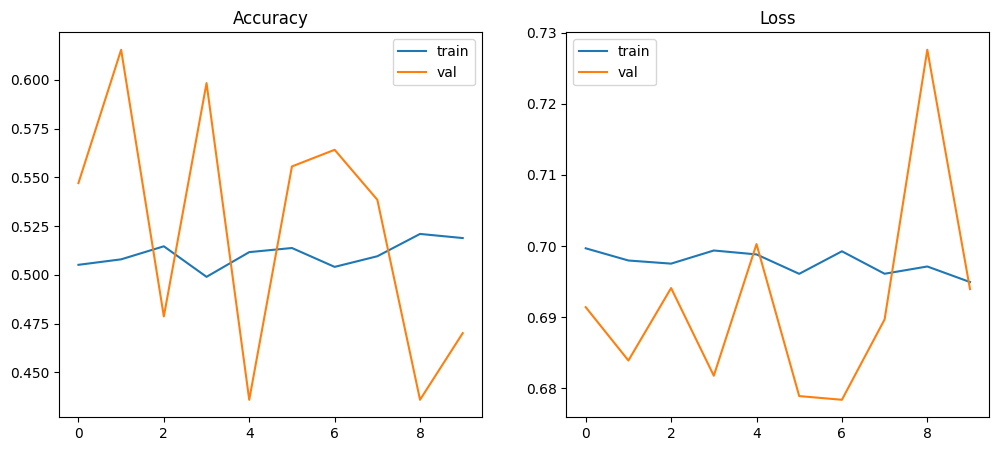

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.show()


In [38]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9635 - loss: 0.1042 
Test Accuracy: 0.9673202633857727


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


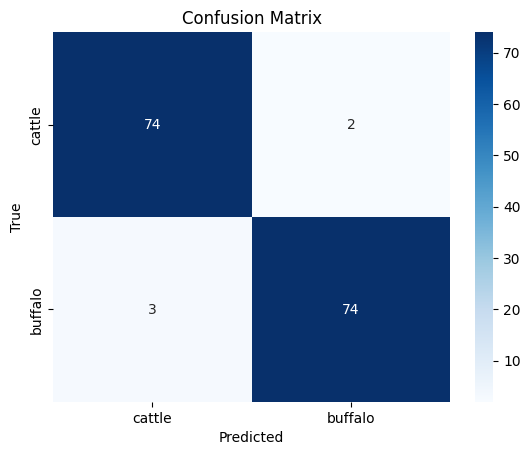

              precision    recall  f1-score   support

      cattle       0.96      0.97      0.97        76
     buffalo       0.97      0.96      0.97        77

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



In [39]:
y_true = []
y_pred = []

for img, label in test_ds:
    preds = model.predict(img)
    y_pred.extend((preds > 0.5).astype("int32"))
    y_true.extend(label.numpy().astype("int32"))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["cattle","buffalo"],
    yticklabels=["cattle","buffalo"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(
    y_true, y_pred,
    target_names=["cattle","buffalo"]
))


In [40]:
model.save("cattle_buffalo_effb3.keras")


In [41]:
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model("cattle_buffalo_effb3.keras")


# define representative dataset for calibration
def representative_dataset():
    for images, _ in train_ds.take(100):
        # First image of the batch
        yield [tf.cast(images[0:1], tf.float32)]
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# set representative function
converter.representative_dataset = representative_dataset

# full integer quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# force int8 input/output
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# convert
tflite_model = converter.convert()

# save file
with open("cattle_buffalo_effb3_INT8_full.tflite", "wb") as f:
    f.write(tflite_model)

print("Full INT8 TFLite model saved.")


INFO:tensorflow:Assets written to: /tmp/tmph42gga_s/assets


INFO:tensorflow:Assets written to: /tmp/tmph42gga_s/assets


Saved artifact at '/tmp/tmph42gga_s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139835587756688: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139835587758992: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139851868133840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139835847279056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139835847294800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139835847294416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139835847293072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139835847293840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139836249507216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139836249506256: TensorSpec(shape=(), dtype=tf.resource, name=Non

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1765199171.106965      47 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1765199171.107015      47 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Full INT8 TFLite model saved.
